## **This script will interpolate data from an arbitrary grid to the user-specified MOM grid**

## **Interpolation procedure**

In [14]:
import os
import sys
import numpy as np
import matplotlib.pyplot as pl
import netCDF4
from netCDF4 import Dataset
import seawater as sw
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
import concurrent.futures 
import time as ti
import platform
import gsw
import warnings
import xarray as xr

#crop = [lat_min, lat_max, lon_min, lon_max]
class mom_fields_interpolation:
    
    def __init__(self, path2mom_grid):
        self.mom_grid_path = path2mom_grid
    
    #dim_names, var_names = ['longitude', 'latitude', 'depth', 'time'] last element in var_names list - name of arbitrary variable
    def get_non_mom_grid_data(self, dimensions_names, variables_names):
        self.var_names = variables_names
        self.dim_names = dimensions_names
        warnings.warn("Not MOM grid has been chosen. All u-grid variables will be treated as t-grid variables")
        mom_grid = xr.load_dataset(self.mom_grid_path)
        self.mom_depths_t = mom_grid[self.var_names[2]].data
        tmp_var = mom_grid[self.var_names[-1]]
        mask_ocean = eval(f"1 * np.ones((tmp_var.shape[1], tmp_var.shape[2], tmp_var.shape[3])) * np.isfinite(tmp_var.isel({self.dim_names[-1]}=0))") 
        mask_land = eval(f"0 * np.ones((tmp_var.shape[1], tmp_var.shape[2], tmp_var.shape[3])) * np.isnan(tmp_var.isel({self.dim_names[-1]}=0))")   
        mom_mask_t = mask_ocean[0,:,:] + mask_land[0,:,:]
        mom_nlev_t = mask_ocean + mask_land
        mom_nlev_t = np.sum(mom_nlev_t, axis = 0)
        adjusted_depth = np.append(0,mom_grid[self.var_names[2]].data)
        depth_t = np.take(adjusted_depth, mom_nlev_t)
        
        mom_grid['mask_t'] = ((self.dim_names[1], self.dim_names[0]), mom_mask_t)
        mom_grid['nlev_t'] = ((self.dim_names[1], self.dim_names[0]), mom_nlev_t)
        mom_grid['depth_t'] = ((self.dim_names[1], self.dim_names[0]), depth_t)
        
        if self.crop:
            print('Model domain will be cropped according to your criterions')
            self.mom_lats_t = eval(f"mom_grid.{self.var_names[1]}.sel({self.dim_names[1]} = slice(self.crop[0], self.crop[1])).data")
            self.mom_lons_t = eval(f"mom_grid.{self.var_names[0]}.sel({self.dim_names[0]} = slice(self.crop[2], self.crop[3])).data")
            self.mom_depth_t = eval(f"mom_grid.depth_t.sel({self.dim_names[1]} = slice(self.crop[0], self.crop[1]), {self.dim_names[0]} = slice(self.crop[2], self.crop[3])).data")
            self.mom_nlev_t = eval(f"mom_grid.nlev_t.sel({self.dim_names[1]} = slice(self.crop[0], self.crop[1]), {self.dim_names[0]} = slice(self.crop[2], self.crop[3])).data")
            self.mom_mask_t = eval(f"mom_grid.mask_t.sel({self.dim_names[1]} = slice(self.crop[0], self.crop[1]), {self.dim_names[0]} = slice(self.crop[2], self.crop[3])).data")
            self.mom_lats_u = self.mom_lats_t.copy()
            self.mom_lons_u = self.mom_lons_t.copy()
            self.mom_mask_u = self.mom_mask_t.copy()
            print(f'The shape of the cropped data is: {self.mom_mask_t.shape}\n')
            
        elif not self.crop:
            self.mom_lats_t = mom_grid[self.var_names[1]].data
            self.mom_lons_t = mom_grid[self.var_names[0]].data
            self.mom_depth_t = mom_grid[self.var_names[2]].data
            self.mom_nlev_t = mom_grid['nlev_t'].data
            self.mom_mask_t = mom_grid['mask_t'].data
            self.mom_lats_u = self.mom_lats_t.copy()
            self.mom_lons_u = self.mom_lons_t.copy()
            self.mom_mask_u = self.mom_mask_t.copy()
        
#         print(f'latst: {self.mom_lats_t}\n')
#         print(f'lonst: {self.mom_lons_t}\n')
#         print(f'deptht: {self.mom_depths_t}\n')
        
#         fig = pl.figure()
#         pl.pcolormesh(self.mom_nlev_t)
#         pl.colorbar()
#         pl.title('nlev')
#         pl.show()
        
#         fig = pl.figure()
#         pl.pcolormesh(self.mom_mask_t)
#         pl.colorbar()
#         pl.title('mask')
#         pl.show()
        
#         fig = pl.figure()
#         pl.pcolormesh(self.mom_depth_t)
#         pl.colorbar()
#         pl.title('depth')
#         pl.show()

        
    def get_mom_grid_data(self):
        mom_grid = xr.load_dataset(self.mom_grid_path)
        ustepx = (mom_grid.grid_x_T.isel(grid_x_T = 1) - mom_grid.grid_x_T.isel(grid_x_T = 0)).data * 0.5
        ustepy = (mom_grid.grid_y_T.isel(grid_y_T = 1) - mom_grid.grid_y_T.isel(grid_y_T = 0)).data * 0.5
        self.mom_depths_t = mom_grid['zt'].data
        if self.crop:
            print('Model domain will be cropped according to your criterions')
            self.mom_lats_t = mom_grid['grid_y_T'].sel(grid_y_T = slice(self.crop[0], self.crop[1])).data
            self.mom_lons_t = mom_grid['grid_x_T'].sel(grid_x_T = slice(self.crop[2], self.crop[3])).data
            self.mom_depth_t = mom_grid['depth_t'].sel(grid_y_T = slice(self.crop[0], self.crop[1]), grid_x_T = slice(self.crop[2], self.crop[3])).data
            self.mom_nlev_t = mom_grid['num_levels'].sel(grid_y_T = slice(self.crop[0], self.crop[1]), grid_x_T = slice(self.crop[2], self.crop[3])).data
            self.mom_lats_u = mom_grid['grid_y_C'].sel(grid_y_C = slice(self.crop[0]+ustepy, self.crop[1]+ustepy)).data
            self.mom_lons_u = mom_grid['grid_x_C'].sel(grid_x_C = slice(self.crop[2]+ustepx, self.crop[3]+ustepx)).data
            
            if 'wet_c' not in list(mom_grid.keys()):
                warnings.warn("Land-sea mask for u-grid has not been found, mask for t-grid will be used instead")
                self.mom_mask_t = mom_grid['wet'].sel(grid_y_T = slice(self.crop[0], self.crop[1]), grid_x_T = slice(self.crop[2], self.crop[3])).data
                self.mom_mask_u = mom_grid['wet'].sel(grid_y_T = slice(self.crop[0], self.crop[1]), grid_x_T = slice(self.crop[2], self.crop[3])).data
            else:
                self.mom_mask_t = mom_grid['wet'].sel(grid_y_T = slice(self.crop[0], self.crop[1]), grid_x_T = slice(self.crop[2], self.crop[3])).data
                self.mom_mask_u = mom_grid['wet_c'].sel(grid_y_C = slice(self.crop[0]+ustepy, self.crop[1]+ustepy), grid_x_C = slice(self.crop[2]+ustepx, self.crop[3]+ustepx)).data
        
        elif not self.crop:
            self.mom_lats_t = mom_grid['grid_y_T'].data
            self.mom_lons_t = mom_grid['grid_x_T'].data
            self.mom_depth_t = mom_grid['depth_t'].data
            self.mom_nlev_t = mom_grid['num_levels'].data
            self.mom_lats_u = mom_grid['grid_y_C'].data
            self.mom_lons_u = mom_grid['grid_x_C'].data

            if 'wet_c' not in list(mom_grid.keys()):
                warnings.warn("Land-sea mask for u-grid has not been found, mask for t-grid will be used instead")
                self.mom_mask_t = mom_grid['wet'].data
                self.mom_mask_u = mom_grid['wet'].data
            else:
                self.mom_mask_t = mom_grid['wet'].data
                self.mom_mask_u = mom_grid['wet_c'].data
                
    def interpolation2d(self, x_m, y_m, x, y, values):
        
        #Linear interpolation method (2d case)
        def go_linear2d(int_values, x_int, y_int, x_d, y_d):
            interpol = interp2d(x_int, y_int, int_values)
            ans = interpol(x_d, y_d)[0]
            flag = 2
            return ans, flag
        
        #Linear interpolation method (1d case)
        def go_linear1d(int_values, x_int, x_d):
            interpol = interp1d(x_int, int_values)
            ans = interpol(x_d)
            flag = 1
            return ans, flag
        
        #Nearest neighbor interpolation method
        def go_nn(x, y, x_m, y_m, values):
            flag = 1
            def calc_dist(phi1, phi2, lamb1, lamb2):
                earth_radius = 6371000. #m
                prefix = 2 * earth_radius * 1e-3
                arg1 = np.deg2rad(0.5 * (phi2 - phi1))
                arg2 = np.deg2rad(phi1)
                arg3 = np.deg2rad(phi2)
                arg4 = np.deg2rad(0.5 * (lamb2 - lamb1))
                return prefix * np.arcsin(np.deg2rad(np.sqrt(np.sin(arg1)**2 + np.cos(arg2)*np.cos(arg3)*np.sin(arg4)**2)))
            
            xx, yy = np.meshgrid(x, y)
            flag = 1
            dist = calc_dist(yy, y_m, xx, x_m)     
            min_dist_in = np.where(dist == dist.min())
            while flag == 1:
                min_dist_in = np.where(dist == dist.min())
                value = values[min_dist_in]
                for k in range(len(value)):
                    if np.ma.is_masked(value[k]) == False:
                        ans = value[k]
                        flag = 0
                        break
                dist[min_dist_in] = dist.max()
            return ans, flag
                        
        int_x = []; int_y = []; check_sum = 0
        x_int_x = []; y_int_y = []
            
        #Finding x borders for interpolation
        lx_in = np.where(x <= x_m)[0]
        ux_in = np.where(x >= x_m)[0]
        
        if len(lx_in) != 0:
            int_x.append(lx_in[-1]) # x-*-*
            x_int_x.append(x[lx_in[-1]]) # Longitude with lower index 
        if len(ux_in) != 0:
            int_x.append(ux_in[0]) # *-*-x
            x_int_x.append(x[ux_in[0]]) # Longitude with upper index 
        
        for i in range(len(int_x)):
            check_sum += 1
        
        #Finding y borders for interpolation
        ly_in = np.where(y < y_m)[0]
        uy_in = np.where(y > y_m)[0]
        
        if len(ly_in) != 0:
            int_y.append(ly_in[-1]) # y-*-*
            y_int_y.append(y[ly_in[-1]]) # Latitude with lower index 
        if len(uy_in) != 0:
            int_y.append(uy_in[0]) # *-*-y
            y_int_y.append(y[uy_in[0]]) # Latitude with upper index 
            
        for i in range(len(int_y)):
            check_sum += 1
            
        if check_sum != 4:
            interpolated_value, int_flag = go_nn(x, y, x_m, y_m, values)
            
        elif np.ma.is_masked(values[int_y[0], int_x[0]]) == True or \
        np.ma.is_masked(values[int_y[0], int_x[1]]) == True or \
        np.ma.is_masked(values[int_y[1], int_x[0]]) == True or \
        np.ma.is_masked(values[int_y[1], int_x[1]]) == True:
            
            interpolated_value, int_flag = go_nn(x, y, x_m, y_m, values)
            
        elif int_x[0] == int_x[1]:
            int_array = np.array([values[int_y[0], int_x[0]], values[int_y[1], int_x[0]]])
            interpolated_value, int_flag = go_linear1d(int_array, y_int_y, y_m)
            
        elif int_y[0] == int_y[1]:
            int_array = np.array([values[int_y[0], int_x[0]], values[int_y[0], int_x[1]]])
            interpolated_value, int_flag = go_linear1d(int_array, x_int_x, x_m)
            
        elif int_y[0] == int_y[1] and int_x[0] == int_x[1]:
            interpolated_value, int_flag = values[int_y[0], int_x[0]], 5
            
        else:
            int_array = np.array([ [values[int_y[0], int_x[0]], values[int_y[0], int_x[1]]], [values[int_y[1], int_x[0]], values[int_y[1], int_x[1]]] ])
            interpolated_value, int_flag = go_linear2d(int_array, x_int_x, y_int_y, x_m, y_m)
            
        return interpolated_value, int_flag
    
    
    def interpolation1d(self, x_m, x, values):
        
        #Linear interpolation method
        def go_linear(int_values, x_int, x_d):
            interpol = interp1d(x_int, int_values)
            ans = interpol(x_d)
            flag = 1
            return ans, flag
        
        #Nearest neighbor interpolation method
        def go_nn(x, x_m, values):
            flag = 1
            dist = np.abs(x - x_m)
            while flag == 1:
                min_dist_in = np.where(dist == dist.min())[0]
                value = values[min_dist_in]
                try:
                    for k in range(len(value)):
                        if np.ma.is_masked(value[k]) == False:
                            ans = value[k]
                            flag = 0
                            break
                    dist[min_dist_in] = dist.max()
                except TypeError:
                    if np.ma.is_masked(value) == False:
                            ans = value
                            flag = 0
                    else:
                        dist[min_dist_in] = dist.max()
            return ans, flag
                        
        int_x = []; x_int_x = []; check_sum = 0
            
        #Finding x borders for interpolation
        
        lx_in = np.where(x <= x_m)[0]
        ux_in = np.where(x >= x_m)[0]
        
        if len(lx_in) != 0:
            int_x.append(lx_in[-1]) # x-*-*
            x_int_x.append(x[lx_in[-1]]) # X value with lower index 
        if len(ux_in) != 0:
            int_x.append(ux_in[0]) # *-*-x
            x_int_x.append(x[ux_in[0]]) #  X value with upper index 
        
        for i in range(len(int_x)):
            check_sum += 1
        
        if check_sum != 2:
            interpolated_value, int_flag = go_nn(x, x_m, values)
        elif np.ma.is_masked(values[int_x[0]]) == True or np.ma.is_masked(values[int_x[1]]) == True:
            interpolated_value, int_flag = go_nn(x, x_m, values)
        elif int_x[0] == int_x[1]:
            interpolated_value, int_flag = values[int_x[0]]
        else:
            int_array = np.array([values[int_x[0]], values[int_x[1]]])
            interpolated_value, int_flag = go_linear(int_array, x_int_x, x_m)
        
        return interpolated_value, int_flag
    
    def divisorGenerator(self, n):
        large_divisors = []
        for i in range(1, int(np.sqrt(n) + 1)):
            if n % i == 0:
                yield i
                if i*i != n:
                    large_divisors.append(int(n / i))
        for divisor in reversed(large_divisors):
            yield divisor
    
    def go_parallel(self):
        n_cpus = os.cpu_count()
        dividers_ty = sorted(np.array(list(self.divisorGenerator(len(self.mom_lats_t))), dtype = np.int32), reverse = True)
        dividers_uy = sorted(np.array(list(self.divisorGenerator(len(self.mom_lats_u))), dtype = np.int32), reverse = True)
        dividers_tx = sorted(np.array(list(self.divisorGenerator(len(self.mom_lons_t))), dtype = np.int32), reverse = True)
        dividers_ux = sorted(np.array(list(self.divisorGenerator(len(self.mom_lons_u))), dtype = np.int32), reverse = True)
        
        correct_indxs_t = np.array([], dtype = np.int32)
        for i in dividers_ty:
            for j in dividers_tx:
                if i*j <= n_cpus:
                    correct_indxs_t = np.append(correct_indxs_t, [i, j])
                    break
            else:
                continue
            break
            
        correct_indxs_u = np.array([], dtype = np.int32)
        for i in dividers_uy:
            for j in dividers_ux:
                if i*j <= n_cpus:
                    correct_indxs_u = np.append(correct_indxs_u, [i, j])
                    break
            else:
                continue
            break
        
        self.n_chunks_tx = correct_indxs_t[-1]
        self.n_chunks_ty = correct_indxs_t[0]
        self.n_chunks_ux = correct_indxs_u[-1]
        self.n_chunks_uy = correct_indxs_u[0]
        
        step_tx = int(len(self.mom_lons_t) / self.n_chunks_tx)
        step_ux = int(len(self.mom_lons_u) / self.n_chunks_ux)
        step_ty = int(len(self.mom_lats_t) / self.n_chunks_ty)
        step_uy = int(len(self.mom_lats_u) / self.n_chunks_uy)
        
        self.mom_lats_tp, self.mom_lats_up = {}, {}
        self.mom_lons_tp, self.mom_lons_up = {}, {}
        
        mom_lats_tp_tmp, mom_lats_up_tmp = [], []
        mom_lats_tp_in_tmp, mom_lats_up_in_tmp = [], []
        
        mom_lons_tp_tmp, mom_lons_up_tmp = [], []
        mom_lons_tp_in_tmp, mom_lons_up_in_tmp = [], []
        
        ny, my = 0, step_ty
        for j in range(self.n_chunks_ty):
            nx, mx = 0, step_tx
            for i in range(self.n_chunks_tx):
                mom_lons_tp_tmp.append(self.mom_lons_t[nx:mx])
                mom_lons_tp_in_tmp.append(np.arange(nx, mx, dtype = np.int32))
                mom_lats_tp_tmp.append(self.mom_lats_t[ny:my])
                mom_lats_tp_in_tmp.append(np.arange(ny, my, dtype = np.int32))
                nx += step_tx; mx += step_tx
                self.mom_lats_tp['lats'] = mom_lats_tp_tmp
                self.mom_lats_tp['indxs'] = mom_lats_tp_in_tmp
                self.mom_lons_tp['lons'] = mom_lons_tp_tmp
                self.mom_lons_tp['indxs'] = mom_lons_tp_in_tmp
            ny += step_ty; my += step_ty
            
        ny, my = 0, step_uy
        for j in range(self.n_chunks_uy):
            nx, mx = 0, step_ux
            for i in range(self.n_chunks_ux):
                mom_lons_up_tmp.append(self.mom_lons_u[nx:mx])
                mom_lons_up_in_tmp.append(np.arange(nx, mx, dtype = np.int32))
                mom_lats_up_tmp.append(self.mom_lats_u[ny:my])
                mom_lats_up_in_tmp.append(np.arange(ny, my, dtype = np.int32))
                nx += step_ux; mx += step_ux
                self.mom_lats_up['lats'] = mom_lats_up_tmp
                self.mom_lats_up['indxs'] = mom_lats_up_in_tmp
                self.mom_lons_up['lons'] = mom_lons_up_tmp
                self.mom_lons_up['indxs'] = mom_lons_up_in_tmp
            ny += step_uy; my += step_uy
                       
    def check_domain(self, lat_mod, lat_sample, lon_mod, lon_sample):
        if lat_mod[0] < lat_sample[0] or lat_mod[-1] > lat_sample[-1] or lon_mod[0] < lon_sample[0] or lon_mod[-1] > lon_sample[-1]:
            raise ValueError("Model domain should be fully covered with data, check your input")
            
    def get_sample_data(self, path2init_fields):
        self.var2d = 0
        sample_data_t = {}; sample_data_u = {}; auxilary_data = {}
        tmp_dict = {}; tmp_names = ['attrs', 'data']
        sample_data = Dataset(path2init_fields)
        
        for var in self.aux_variables:
                tmp_dict[tmp_names[0]] = sample_data[var].__dict__
                tmp_dict[tmp_names[-1]] = sample_data[var][:]
                auxilary_data[var] = tmp_dict
                if 'valid_min' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['valid_min']
                if 'valid_max' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['valid_max']
                if '_FillValue' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['_FillValue']
                if 'FillValue' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['_FillValue']
                if 'add_offset' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['add_offset']
                if 'scale_factor' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['scale_factor']
                tmp_dict = {}
                
        for var in list(self.variables.keys()):
            if self.variables[var]['grid_type'] == 'u':
                tmp_dict[tmp_names[0]] = sample_data[var].__dict__
                if 'valid_min' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['valid_min']
                if 'valid_max' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['valid_max']
                if '_FillValue' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['_FillValue']
                if 'FillValue' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['_FillValue']
                if 'add_offset' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['add_offset']
                if 'scale_factor' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['scale_factor']
                tmp_dict[tmp_names[-1]] = np.squeeze(sample_data[var][:,:,:,:])
                sample_data_u[var] = tmp_dict
                tmp_dict = {}
            elif len(sample_data[var].shape) == 3 and (sample_data[var].units == 'cm' or sample_data[var].units == 'm' or sample_data[var].units == 'mm'):
                tmp_dict[tmp_names[0]] = sample_data[var].__dict__
                if 'valid_min' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['valid_min']
                if 'valid_max' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['valid_max']
                if '_FillValue' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['_FillValue']
                if 'FillValue' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['_FillValue']
                if 'add_offset' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['add_offset']
                if 'scale_factor' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['scale_factor']
                tmp_dict[tmp_names[-1]] = np.squeeze(sample_data[var][:,:,:])
                sample_data_t[var] = tmp_dict
                self.var2d = var
                tmp_dict = {}
            elif self.variables[var]['grid_type'] == 't':
                tmp_dict[tmp_names[0]] = sample_data[var].__dict__
                if 'valid_min' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['valid_min']
                if 'valid_max' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['valid_max']
                if '_FillValue' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['_FillValue']
                if 'FillValue' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['_FillValue']
                if 'add_offset' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['add_offset']
                if 'scale_factor' in tmp_dict[tmp_names[0]]:
                    del tmp_dict[tmp_names[0]]['scale_factor']
                tmp_dict[tmp_names[-1]] = np.squeeze(sample_data[var][:,:,:,:])
                sample_data_t[var] = tmp_dict
                tmp_dict = {}
                
        sample_data.close()
        return sample_data_t, sample_data_u, auxilary_data
    
    def get_mom_masks(self):
        self.mom_mask_t3d = np.zeros((len(self.auxilary_data[self.aux_variables[-2]]['data']), len(self.mom_lats_t), len(self.mom_lons_t)))
        self.mom_mask_u3d = np.zeros((len(self.auxilary_data[self.aux_variables[-2]]['data']), len(self.mom_lats_u), len(self.mom_lons_u)))
        self.mom_mask_t3d_2 = np.zeros((len(self.mom_depths_t), len(self.mom_lats_t), len(self.mom_lons_t)))
        self.mom_mask_u3d_2 = np.zeros((len(self.mom_depths_t), len(self.mom_lats_u), len(self.mom_lons_u)))
        
        for z in range(len(self.mom_depths_t)):
            additional_mask_t = np.where((self.mom_nlev_t < z+1) & (self.mom_nlev_t != 0))
            self.mom_mask_t3d_2[z,:,:] = self.mom_mask_t[:,:] * (-1) + 1 
            if len(additional_mask_t[0]) != 0:
                for i in range(len(additional_mask_t[0])):
                    self.mom_mask_t3d_2[z,additional_mask_t[0][i],additional_mask_t[1][i]] = 1
                    
        for z in range(len(self.mom_depths_t)):
            additional_mask_u = np.where((self.mom_nlev_t < z+1) & (self.mom_nlev_t != 0))
            self.mom_mask_u3d_2[z,:,:] = self.mom_mask_u[:,:] * (-1) + 1 
            if len(additional_mask_u[0]) != 0:
                for i in range(len(additional_mask_u[0])):
                    self.mom_mask_u3d_2[z,additional_mask_u[0][i],additional_mask_u[1][i]] = 1
        
        for z in range(len(self.auxilary_data[self.aux_variables[-2]]['data'])):
            additional_mask_t = np.where((self.auxilary_data[self.aux_variables[-2]]['data'][z] > self.mom_depth_t) & (self.mom_depth_t != 0))
            self.mom_mask_t3d[z,:,:] = self.mom_mask_t[:,:] * (-1) + 1 
            if len(additional_mask_t[0]) != 0:
                for i in range(len(additional_mask_t[0])):
                    self.mom_mask_t3d[z,additional_mask_t[0][i],additional_mask_t[1][i]] = 1
                    
        for z in range(len(self.auxilary_data[self.aux_variables[-2]]['data'])):
            additional_mask_u = np.where((self.auxilary_data[self.aux_variables[-2]]['data'][z] > self.mom_depth_t) & (self.mom_depth_t != 0))
            self.mom_mask_u3d[z,:,:] = self.mom_mask_u[:,:] * (-1) + 1 
            if len(additional_mask_u[0]) != 0:
                for i in range(len(additional_mask_u[0])):
                    self.mom_mask_u3d[z,additional_mask_u[0][i],additional_mask_u[1][i]] = 1
            
    def interpolate_initial_fields(self, lats, lons, indxs_la, indxs_lo):
        
        if self.current_grid_type == 't':
            print('t interpolation')
            preliminary_interp = np.ma.array(np.zeros((len(self.auxilary_data[self.aux_variables[-2]]['data']), len(lats), len(lons))), mask = self.mom_mask_t3d[:,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])
            int_flag = np.ma.array(np.zeros((len(self.auxilary_data[self.aux_variables[-2]]['data']), len(lats), len(lons))), mask = self.mom_mask_t3d[:,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])
            final_interp = np.ma.array(np.zeros((len(self.mom_depths_t), len(lats), len(lons))), mask = self.mom_mask_t3d_2[:,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])
            int_flag_z = np.ma.array(np.zeros((len(self.mom_depths_t), len(lats), len(lons))), mask = self.mom_mask_t3d_2[:,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])
            
            print(preliminary_interp.shape)
            print(final_interp.shape)
            
            fig = pl.figure()
            pl.pcolormesh(preliminary_interp[0,:,:])
            pl.title('preliminary')
            pl.colorbar()
            pl.show()
            
            fig = pl.figure()
            pl.pcolormesh(final_interp[0,:,:])
            pl.colorbar()
            pl.title('final')
            pl.show()
            
            fig = pl.figure()
            pl.pcolormesh(self.mom_mask_t3d[0,:,:])
            pl.colorbar()
            pl.title('mask3d')
            pl.show()
            
            
            #1st phase of interpolation: 2D interpolation on Lat/Lon plane at all levels
            for i in range(len(lats)):
                for j in range(len(lons)):
                    for z in range(len(self.auxilary_data[self.aux_variables[-2]]['data'])):
                        if preliminary_interp.mask[z,i,j] == False:
                            preliminary_interp[z,i,j], int_flag[z,i,j] = self.interpolation2d(lons[j], 
                                                                                         lats[i], 
                                                                                         self.auxilary_data[self.aux_variables[0]]['data'], 
                                                                                         self.auxilary_data[self.aux_variables[1]]['data'], 
                                                                                         self.sample_data_t[self.current_var]['data'][self.time_step,z,:,:])
            #2nd phase of interpolation: 1D interpolation to model levels
                    for zm in range(len(self.mom_depths_t)):
                        if final_interp.mask[zm,i,j] == False:
                            final_interp[zm,i,j], int_flag_z[zm,i,j] = self.interpolation1d(self.mom_depths_t[zm], 
                                                                                         self.auxilary_data[self.aux_variables[-2]]['data'], 
                                                                                         preliminary_interp[:,i,j])
        elif self.current_grid_type == 'u':
            preliminary_interp = np.ma.array(np.zeros((len(self.auxilary_data[self.aux_variables[-2]]['data']), len(lats), len(lons))), mask = self.mom_mask_u3d[:,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])
            int_flag = np.ma.array(np.zeros((len(self.auxilary_data[self.aux_variables[-2]]['data']), len(lats), len(lons))), mask = self.mom_mask_u3d[:,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])
            final_interp = np.ma.array(np.zeros((len(self.mom_depths_t), len(lats), len(lons))), mask = self.mom_mask_u3d_2[:,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])
            int_flag_z = np.ma.array(np.zeros((len(self.mom_depths_t), len(lats), len(lons))), mask = self.mom_mask_u3d_2[:,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])

            #1st phase of interpolation: 2D interpolation on Lat/Lon plane at all levels
            for i in range(len(lats)):
                for j in range(len(lons)):
                    for z in range(len(self.auxilary_data[self.aux_variables[-2]]['data'])):
                        if preliminary_interp.mask[z,i,j] == False:
                            preliminary_interp[z,i,j], int_flag[z,i,j] = self.interpolation2d(lons[j], 
                                                                                         lats[i], 
                                                                                         self.auxilary_data[self.aux_variables[0]]['data'], 
                                                                                         self.auxilary_data[self.aux_variables[1]]['data'], 
                                                                                         self.sample_data_u[self.current_var]['data'][self.time_step,z,:,:])
            #2nd phase of interpolation: 1D interpolation to model levels
                    for zm in range(len(self.mom_depths_t)):
                        if final_interp.mask[zm,i,j] == False:
                            final_interp[zm,i,j], int_flag_z[zm,i,j] = self.interpolation1d(self.mom_depths_t[zm], 
                                                                                         self.auxilary_data[self.aux_variables[-2]]['data'], 
                                                                                         preliminary_interp[:,i,j])
        elif self.current_grid_type == '2d':
            print('2d interpolation')
            int_flag = np.ma.array(np.zeros((len(lats), len(lons))), mask = self.mom_mask_t3d_2[0,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])
            final_interp = np.ma.array(np.zeros((len(lats), len(lons))), mask = self.mom_mask_t3d_2[0,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])
            int_flag_z = np.ma.array(np.zeros((len(lats), len(lons))), mask = self.mom_mask_t3d_2[0,indxs_la[0]:indxs_la[-1]+1,indxs_lo[0]:indxs_lo[-1]+1])

            #2D interpolation on Lat/Lon plane at all levels
            for i in range(len(lats)):
                for j in range(len(lons)):
                    if final_interp.mask[i,j] == False:
                        final_interp[i,j], int_flag[i,j] = self.interpolation2d(lons[j], 
                                                                             lats[i], 
                                                                             self.auxilary_data[self.aux_variables[0]]['data'], 
                                                                             self.auxilary_data[self.aux_variables[1]]['data'], 
                                                                             self.sample_data_t[self.current_var]['data'][self.time_step,:,:])
        return final_interp, int_flag, int_flag_z
    
    def save_results(self, final_interp, int_flag, int_flag_z):
        
        t_lat_attrs = {
            'units': "degrees_north",
            'point_spacing': "even",
            'axis': 'Y'
        }
        
        t_lon_attrs = {
            'units': "degrees_east",
            'modulo': 360.0,
            'point_spacing': "even",
            'axis': 'X'
        }
        
        u_lat_attrs = {
            'units': "degrees_north",
            'point_spacing': "uneven",
            'axis': 'Y'
        }
        
        u_lon_attrs = {
            'units': "degrees_east",
            'modulo': 360.0,
            'point_spacing': "uneven",
            'axis': 'X'
        }
        
        dep_attrs = {
              'units': "meters",
              'positive': "down",
              'point_spacing': "uneven",
              'axis': "Z"
        }
        
        sur_atts = {
              'long_name': "Depth of surface",
              'units': "m",
              'positive': "down",
              'point_spacing': "even",
              'axis': "Z"
        }
        
        output_paths = []; paths_and_vars = {}; dummy_dict = {}
        for var in list(self.variables.keys()):
            output_paths.append(self.variables[var]['output_file'])
        output_paths = list(dict.fromkeys(output_paths))
        for path in output_paths:
            for var in list(self.variables.keys()):
                if self.variables[var]['output_file'] == path:
                    dummy_dict[var] = var
            paths_and_vars[path] = dummy_dict
            dummy_dict = {}
        
        path = output_paths[0].split('/')[:-1]
        path = '/'.join(path)+'/'
        tmp_dat = Dataset(path+'interpolation_log.nc', 'w', format="NETCDF4")
        tmp_dat.description = "Auto-generated file with some infromation about how the interpolation was done"
        tmp_dat.history = "Created " + ti.ctime(ti.time()) + " on " + str(platform.system()) + ", ver. " + str(platform.release())
        
        lat_t = tmp_dat.createDimension("GRID_Y_T", len(self.mom_lats_t))
        lon_t = tmp_dat.createDimension("GRID_X_T", len(self.mom_lons_t))
        lat_u = tmp_dat.createDimension("GRID_Y_C", len(self.mom_lats_u))
        lon_u = tmp_dat.createDimension("GRID_X_C", len(self.mom_lons_u))
        depth = tmp_dat.createDimension("ZT", len(self.mom_depths_t))
        time = tmp_dat.createDimension("TIME", len(self.auxilary_data[self.aux_variables[-1]]['data']))
        depth2 = tmp_dat.createDimension("Z_ORIG", len(self.auxilary_data[self.aux_variables[-2]]['data']))
        lats_t = tmp_dat.createVariable("GRID_Y_T","f8",("GRID_Y_T",), zlib=True)
        lons_t = tmp_dat.createVariable("GRID_X_T","f8",("GRID_X_T",), zlib=True)
        lats_u = tmp_dat.createVariable("GRID_Y_C","f8",("GRID_Y_C",), zlib=True)
        lons_u = tmp_dat.createVariable("GRID_X_C","f8",("GRID_X_C",), zlib=True)
        depths = tmp_dat.createVariable("ZT","f8",("ZT",), zlib=True)
        depths2 = tmp_dat.createVariable("Z_ORIG","f8",("Z_ORIG",), zlib=True)
        times = tmp_dat.createVariable("TIME","f8",("TIME",), zlib=True)
        times[:] = self.auxilary_data[self.aux_variables[-1]]['data']
        lats_t[:] = self.mom_lats_t
        lons_t[:] = self.mom_lons_t
        lats_u[:] = self.mom_lats_u
        lons_u[:] = self.mom_lons_u
        depths[:] = self.mom_depths_t
        depths2[:] = self.auxilary_data[self.aux_variables[-2]]['data']
        lats_t.setncatts(t_lat_attrs)
        lons_t.setncatts(t_lon_attrs)
        lats_u.setncatts(u_lat_attrs)
        lons_u.setncatts(u_lon_attrs)
        depths.setncatts(dep_attrs)
        times.setncatts(self.auxilary_data[self.aux_variables[-1]]['attrs'])
        depths2.setncatts(self.auxilary_data[self.aux_variables[-2]]['attrs'])
        
        for var in list(self.variables.keys()):
            if len(int_flag[var].shape) == 2:
                tmp_var = tmp_dat.createVariable("IntFlag_"+var,"f8",("TIME", "GRID_Y_T", "GRID_X_T",), zlib=True)
                tmp_var[:,:,:] = int_flag[var]
                tmp_var2 = tmp_dat.createVariable("IntFlagZ_"+var,"f8",("TIME", "GRID_Y_T", "GRID_X_T",), zlib=True)
                tmp_var2[:,:,:] = int_flag_z[var]
            elif self.variables[var]['grid_type'] == 't':
                tmp_var = tmp_dat.createVariable("IntFlag_"+var,"f8",("TIME", "Z_ORIG", "GRID_Y_T", "GRID_X_T",), zlib=True)
                tmp_var2 = tmp_dat.createVariable("IntFlagZ_"+var,"f8",("TIME", "ZT", "GRID_Y_T", "GRID_X_T",), zlib=True)
                tmp_var[:,:,:,:] = int_flag[var]
                tmp_var2[:,:,:,:] = int_flag_z[var]
            elif self.variables[var]['grid_type'] == 'u':
                tmp_var = tmp_dat.createVariable("IntFlag_"+var,"f8",("TIME", "Z_ORIG", "GRID_Y_C", "GRID_X_C",), zlib=True)
                tmp_var2 = tmp_dat.createVariable("IntFlagZ_"+var,"f8",("TIME", "ZT", "GRID_Y_C", "GRID_X_C",), zlib=True)
                tmp_var[:,:,:,:] = int_flag[var]
                tmp_var2[:,:,:,:] = int_flag_z[var]
            tmp_var2.long_name = 'Interpolation type for 1D interpolation in depth plane for variable '+var
            tmp_var2.units = '0 - nearest neighbour; 1 - 1D linear'
            tmp_var.long_name = 'Interpolation type for 2D interpolation in lat/lon plane for variable '+var
            tmp_var.units = '0 - nearest neighbour; 1 - 1D linear; 2 - 2D linear'
        tmp_dat.close()
            
        for file in output_paths:
            vars_in_file = list(paths_and_vars[file].keys())
            tmp_dat = Dataset(file, 'w', format="NETCDF4")
            tmp_dat.description = "Fileds interpolated to user defined grid"
            tmp_dat.history = "Created " + ti.ctime(ti.time()) + " on " + str(platform.system()) + ", ver. " + str(platform.release())
            
            time = tmp_dat.createDimension("TIME", len(self.auxilary_data[self.aux_variables[-1]]['data']))
            times = tmp_dat.createVariable("TIME","f8",("TIME",), zlib=True)
            times[:] = self.auxilary_data[self.aux_variables[-1]]['data']
            times.setncatts(self.auxilary_data[self.aux_variables[-1]]['attrs'])
            
            if self.variables[vars_in_file[0]]['grid_type'] == 't':
                lat = tmp_dat.createDimension("GRID_Y_T", len(self.mom_lats_t))
                lon = tmp_dat.createDimension("GRID_X_T", len(self.mom_lons_t))
                
                latitudes = tmp_dat.createVariable("GRID_Y_T","f8",("GRID_Y_T",), zlib=True)      
                latitudes.setncatts(t_lat_attrs)
                latitudes[:] = self.mom_lats_t
                
                longitudes = tmp_dat.createVariable("GRID_X_T","f8",("GRID_X_T",), zlib=True)              
                longitudes.setncatts(t_lon_attrs)
                longitudes[:] = self.mom_lons_t
                
            elif self.variables[vars_in_file[0]]['grid_type'] == 'u':
                lat = tmp_dat.createDimension("GRID_Y_C", len(self.mom_lats_u))
                lon = tmp_dat.createDimension("GRID_X_C", len(self.mom_lons_u))
                
                latitudes = tmp_dat.createVariable("GRID_Y_C","f8",("GRID_Y_C",), zlib=True)
                latitudes.setncatts(u_lat_attrs)
                latitudes[:] = self.mom_lats_u
                
                longitudes = tmp_dat.createVariable("GRID_X_C","f8",("GRID_X_C",), zlib=True)        
                longitudes.setncatts(u_lon_attrs)
                longitudes[:] = self.mom_lons_u
                
            # t/u grid and 3D fields    
            if (self.variables[vars_in_file[0]]['grid_type'] == 't' or self.variables[vars_in_file[0]]['grid_type'] == 'u') and (self.var2d not in vars_in_file):
                d = tmp_dat.createDimension("ZT", len(self.mom_depths_t))
                dep = tmp_dat.createVariable("ZT","f8",("ZT",), zlib=True)
                dep.setncatts(dep_attrs)
                dep[:] = self.mom_depths_t
                
            # t grid and 2D fields
            elif (self.variables[vars_in_file[0]]['grid_type'] == 't') and (self.var2d in vars_in_file):
                s = tmp_dat.createDimension("SURFACE", 1)
                sur = tmp_dat.createVariable("SURFACE","f8",("SURFACE",), zlib=True)      
                sur.setncatts(sur_atts)
                sur[:] = 0
                
            for var in vars_in_file:    
                if self.variables[var]['grid_type'] == 't' and var != self.var2d:
                    tmp_var = tmp_dat.createVariable(self.variables[var]['save_name'],"f8",("TIME", "ZT", "GRID_Y_T", "GRID_X_T",), zlib=True)
                    tmp_var.setncatts(self.sample_data_t[var]['attrs'])
                    tmp_var[:,:,:,:] = final_interp[var]
                    
                elif self.variables[var]['grid_type'] == 't' and var == self.var2d:
                    tmp_var = tmp_dat.createVariable(self.variables[var]['save_name'],"f8",("TIME", "SURFACE", "GRID_Y_T", "GRID_X_T",), zlib=True)
                    tmp_var.setncatts(self.sample_data_t[var]['attrs'])
                    tmp_var[:,:,:] = final_interp[var]
                    
                elif self.variables[var]['grid_type'] == 'u':
                    tmp_var = tmp_dat.createVariable(self.variables[var]['save_name'],"f8",("TIME", "ZT", "GRID_Y_C", "GRID_X_C",), zlib=True)
                    tmp_var.setncatts(self.sample_data_u[var]['attrs'])
                    tmp_var[:,:,:,:] = final_interp[var]
                    
            tmp_dat.close()    
                
    def interpolate_fields_to_mom_grid(self, aux_variables, variables, path2init_fields, crop = None, parallel = True, to_mom = True, dim_names = False, var_names = False):
        self.variables = variables
        self.aux_variables = aux_variables
        self.crop = crop
        
        if to_mom:
            self.get_mom_grid_data()
        elif not to_mom:
            self.get_non_mom_grid_data(dim_names, var_names)
            
        self.sample_data_t, self.sample_data_u, self.auxilary_data = self.get_sample_data(path2init_fields)
        self.check_domain(self.mom_lats_t, self.auxilary_data[self.aux_variables[1]]['data'], self.mom_lons_t, self.auxilary_data[self.aux_variables[0]]['data'])
        self.get_mom_masks()
        final_interp, int_flag, int_flag_z = {}, {}, {} 
        tmp_final_interp2, tmp_int_flag2, tmp_int_flag_z2 = {}, {}, {}
        
        if parallel:
            self.go_parallel()
            print('Since parallel calculations mode has been chosen, model domain will be split into the ', self.n_chunks_ty*self.n_chunks_tx, ' pieces')
            
            for var in list(self.variables.keys()):
                print('Starting to interpolate var: ', var)
                self.current_var = var
                if var == self.var2d:
                    self.current_grid_type = '2d'
                else:
                    self.current_grid_type = self.variables[var]['grid_type']
                tmp_final_interp2[var], tmp_int_flag2[var], tmp_int_flag_z2[var] = [], [], []
                
                for t in range(len(self.auxilary_data[self.aux_variables[-1]]['data'])):
                    self.time_step = t
                    if self.current_grid_type == 't' or self.current_grid_type == '2d':
                        with concurrent.futures.ProcessPoolExecutor() as executor:
                            params = [self.mom_lats_tp['lats'], self.mom_lons_tp['lons'], self.mom_lats_tp['indxs'], self.mom_lons_tp['indxs']]
                            results = executor.map(self.interpolate_initial_fields, *params)
                            results_list1, results_list2, results_list3 = [], [], [] 
                            for out1, out2, out3 in results:
                                results_list1.append(out1)
                                results_list2.append(out2)
                                results_list3.append(out3)

                        tmp_interp, tmp_int_flag, tmp_int_flag_z = [], [], []
                        m, n = 0, self.n_chunks_tx
                        if  self.current_grid_type == '2d':
                            for i in range(self.n_chunks_ty):
                                tmp_interp.append(np.concatenate(results_list1[m:n], axis = 1))
                                tmp_int_flag.append(np.concatenate(results_list2[m:n], axis = 1))
                                tmp_int_flag_z.append(np.concatenate(results_list3[m:n], axis = 1))
                                m = n; n += self.n_chunks_tx
                            tmp_final_interp2[var].append(np.ma.array(np.concatenate(tmp_interp, axis=0), mask = self.mom_mask_t3d_2[0,:,:]))
                            tmp_int_flag2[var].append(np.ma.array(np.concatenate(tmp_int_flag, axis=0), mask = self.mom_mask_t3d[0,:,:]))
                            tmp_int_flag_z2[var].append(np.ma.array(np.concatenate(tmp_int_flag_z, axis=0), mask = self.mom_mask_t3d_2[0,:,:]))

                        elif  self.current_grid_type == 't':
                            for i in range(self.n_chunks_ty):
                                tmp_interp.append(np.concatenate(results_list1[m:n], axis = 2))
                                tmp_int_flag.append(np.concatenate(results_list2[m:n], axis = 2))
                                tmp_int_flag_z.append(np.concatenate(results_list3[m:n], axis = 2))
                                m = n; n += self.n_chunks_tx
                            tmp_final_interp2[var].append(np.ma.array(np.concatenate(tmp_interp, axis=1), mask = self.mom_mask_t3d_2))
                            tmp_int_flag2[var].append(np.ma.array(np.concatenate(tmp_int_flag, axis=1), mask = self.mom_mask_t3d))
                            tmp_int_flag_z2[var].append(np.ma.array(np.concatenate(tmp_int_flag_z, axis=1), mask = self.mom_mask_t3d_2))

                    elif self.current_grid_type == 'u':
                        with concurrent.futures.ProcessPoolExecutor() as executor:
                            params = [self.mom_lats_up['lats'], self.mom_lons_up['lons'], self.mom_lats_up['indxs'], self.mom_lons_up['indxs']]
                            results = executor.map(self.interpolate_initial_fields, *params)
                            results_list1, results_list2, results_list3 = [], [], [] 
                            for out1, out2, out3 in results:
                                results_list1.append(out1)
                                results_list2.append(out2)
                                results_list3.append(out3)

                        tmp_interp, tmp_int_flag, tmp_int_flag_z = [], [], []
                        m, n = 0, self.n_chunks_ux

                        for i in range(self.n_chunks_uy):
                            tmp_interp.append(np.concatenate(results_list1[m:n], axis = 2))
                            tmp_int_flag.append(np.concatenate(results_list2[m:n], axis = 2))
                            tmp_int_flag_z.append(np.concatenate(results_list3[m:n], axis = 2))
                            m = n; n += self.n_chunks_ux
                        tmp_final_interp2[var].append(np.ma.array(np.concatenate(tmp_interp, axis=1), mask = self.mom_mask_u3d_2))
                        tmp_int_flag2[var].append(np.ma.array(np.concatenate(tmp_int_flag, axis=1), mask = self.mom_mask_u3d))
                        tmp_int_flag_z2[var].append(np.ma.array(np.concatenate(tmp_int_flag_z, axis=1), mask = self.mom_mask_u3d_2))
                
                for i in range(len(tmp_final_interp2[var])):
                    tmp_final_interp2[var][i] = np.ma.expand_dims(tmp_final_interp2[var][i], 0)
                    tmp_int_flag2[var][i] = np.ma.expand_dims(tmp_int_flag2[var][i], 0)
                    tmp_int_flag_z2[var][i] = np.ma.expand_dims(tmp_int_flag_z2[var][i], 0)
            
                final_interp[var] = np.ma.concatenate(tmp_final_interp2[var], axis = 0)
                int_flag[var] = np.ma.concatenate(tmp_int_flag2[var], axis = 0)
                int_flag_z[var] = np.ma.concatenate(tmp_int_flag_z2[var], axis = 0)
        
        elif not parallel:
            print('Single calculations mode has been chosen')
            for var in list(self.variables.keys()):
                print('Starting to interpolate var: ', var)
                tmp_final_interp2[var], tmp_int_flag2[var], tmp_int_flag_z2[var] = [], [], []
                self.current_var = var
                if var == self.var2d:
                    self.current_grid_type = '2d'
                else:
                    self.current_grid_type = self.variables[var]['grid_type']
                
                for t in range(len(self.auxilary_data[self.aux_variables[-1]]['data'])):
                    self.time_step = t
                    if self.current_grid_type == 't' or self.current_grid_type == '2d':
                        tmp_i, tmp_fl, tmp_flz = self.interpolate_initial_fields(self.mom_lats_t, 
                                                                                 self.mom_lons_t, 
                                                                                 np.arange(len(self.mom_lats_t), dtype = np.int32), 
                                                                                 np.arange(len(self.mom_lons_t), dtype = np.int32))
                        
                    elif self.current_grid_type == 'u':
                        tmp_i, tmp_fl, tmp_flz = self.interpolate_initial_fields(self.mom_lats_u, 
                                                                                 self.mom_lons_u, 
                                                                                 np.arange(len(self.mom_lats_u), dtype = np.int32), 
                                                                                 np.arange(len(self.mom_lons_u), dtype = np.int32))
                    
                    tmp_final_interp2[var].append(tmp_i)
                    tmp_int_flag2[var].append(tmp_fl)
                    tmp_int_flag_z2[var].append(tmp_flz)
                    
                for i in range(len(tmp_final_interp2[var])):
                    tmp_final_interp2[var][i] = np.ma.expand_dims(tmp_final_interp2[var][i], 0)
                    tmp_int_flag2[var][i] = np.ma.expand_dims(tmp_int_flag2[var][i], 0)
                    tmp_int_flag_z2[var][i] = np.ma.expand_dims(tmp_int_flag_z2[var][i], 0)
            
                final_interp[var] = np.ma.concatenate(tmp_final_interp2[var], axis = 0)
                int_flag[var] = np.ma.concatenate(tmp_int_flag2[var], axis = 0)
                int_flag_z[var] = np.ma.concatenate(tmp_int_flag_z2[var], axis = 0)
                        
        print('Saving results...')            
        self.save_results(final_interp, int_flag, int_flag_z)
                   

In [15]:
def generate_vars_dictionary_init_fields(input_names, output_names, path2save, grid_type):
    
    """ 
    This function will generate a gictionary formatted in a way that will be recognizible for interpolation function
    Params:
    input_names - list containing variable names you want to be interpolated;
    output_names - list containing names you want to be in your interpolated file;
    Warning: input_names and output_names need to be consistent e.g. input_names are ['temperature', 'pressure'], output_names are ['t2m', 'p']
    path2save - list containing the path to file you want to save your results to (with file name and extension)
    grid_type - list containing the type of grid: 't' for t-grid or 'u' for u-grid
    """
    vars_dict = {}
    tmp_keys = ['save_name', 'output_file', 'grid_type']
    whole_list = [output_names, path2save, grid_type]
    for i in range(len(input_names)):
        tmp_dict = {}
        for j in range(len(tmp_keys)):
            tmp_dict[tmp_keys[j]] = whole_list[j][i]
        vars_dict[input_names[i]] = tmp_dict
    return vars_dict

In [16]:
# aux_data_names = ['longitude', 'latitude', 'depth', 'time']

# min_lon = 9.18
# min_lat = 53.86
# max_lon = 30.18
# max_lat = 65.8
# crop = [min_lat, max_lat, min_lon, max_lon]

# for param in ['thetao', 'po4', 'no3', 'nh4']:
#     for year in range(1993,2019):
#         !rm /silod4/naumov/mom_ergom_data_thomas/copernicus_validation_data/interpolation_log.nc
#         print('year: ', year)
#         var_info = generate_vars_dictionary_init_fields([str(param)], [str(param)], 
#                                             ['/silod4/naumov/mom_ergom_data_thomas/copernicus_validation_data/cop_'+str(param)+'_validation_'+str(year)+'_interpolated.nc'], 
#                                             ['t'])
#         interp_fields = mom_fields_interpolation('/silod3/thomas/pocNP/V04/R25/input/grid_spec.nc')
#         interp_fields.interpolate_fields_to_mom_grid(aux_data_names, var_info, '/silod4/naumov/mom_ergom_data_thomas/copernicus_validation_data/cop_'+str(param)+'_validation_'+str(year)+'.nc', crop = crop, parallel = True)


/silos/conda_packages/naumov/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Not MOM grid has been chosen. All u-grid variables will be treated as t-grid variables


Model domain will be cropped according to your criterions
The shape of the cropped data is: (360, 316)

Single calculations mode has been chosen
Starting to interpolate var:  thetao
t interpolation
(1, 360, 316)
(1, 360, 316)


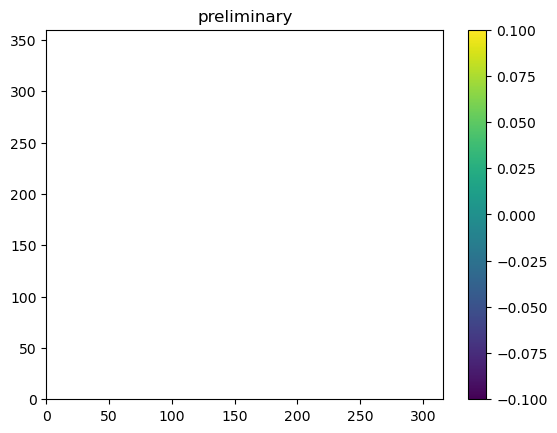

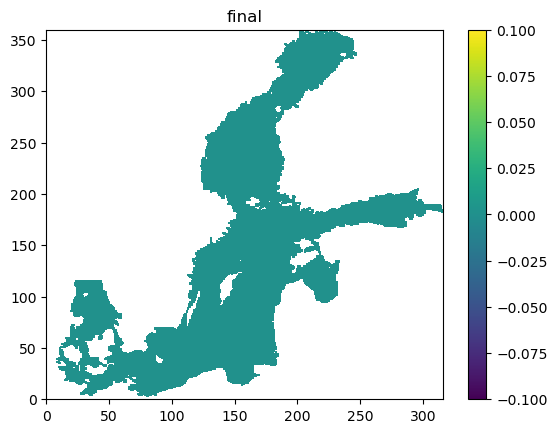

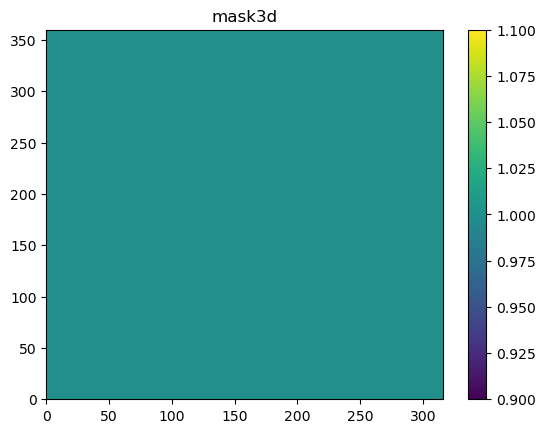

KeyboardInterrupt: 

In [17]:
# Test: interpolation of Copernicus dataset to RCO grid

aux_data_names = ['longitude', 'latitude', 'depth', 'time']

min_lon = 9.0167
min_lat = 53.84163
max_lon = 30.14
max_lat = 65.86
crop = [min_lat, max_lat, min_lon, max_lon]

var_info = generate_vars_dictionary_init_fields(['thetao'],
                                                ['thetao'],
                                                ['/home/nis/safonova/test_interpolation.nc'],
                                                ['t'])

rco_vars_names = ['XAX', 'YAX', 'ZAX', 'TIME', 'VAR004']
rco_dims_names = ['XAX', 'YAX', 'ZAX', 'TIME']

interp_fields = mom_fields_interpolation('/home/nis/naumov/snap1993_lonlat.nc')
interp_fields.interpolate_fields_to_mom_grid(aux_data_names, 
                                             var_info, 
                                             '/home/nis/naumov/cat_CMEMS_BAL_PHY_reanalysis_dailymeans_1993.nc', 
                                             crop = crop, 
                                             parallel = False, 
                                             to_mom = False, 
                                             dim_names = rco_dims_names, 
                                             var_names = rco_vars_names)
